In [1]:
import os
# os.environ["CONDA_PREFIX"] = "/opt/conda" if os.path.exists("/opt/conda") else '/usr/local'
# !pip install -U -q uv

In [2]:
!uv pip install modAL-python mlxtend scikit-learn-intelex tensorflow[and-cuda] scikeras

Audited 5 packages in 115ms


# Imports


In [3]:
import random
import warnings
from pathlib import Path
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.plotting import plot_confusion_matrix
from modAL.disagreement import vote_entropy_sampling
from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling
from sklearnex import patch_sklearn
from keras.metrics import F1Score, Precision
from torcheval.metrics.functional import (
    multiclass_accuracy,
    multiclass_confusion_matrix,
    multiclass_f1_score,
    multiclass_precision,
    multiclass_recall,
)
import torch
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from scikeras.wrappers import KerasClassifier
from tqdm.auto import tqdm
from keras.utils import to_categorical

if not os.path.exists("reports_FashionMNIST"): os.mkdir("reports_FashionMNIST")
patch_sklearn()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Tensorflow version: ", tf.__version__)
print("Current Device: ", tf.test.gpu_device_name())
warnings.filterwarnings("ignore")

2024-05-05 19:44:44.447637: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 19:44:44.728693: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 19:44:44.728727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 19:44:44.773359: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 19:44:44.863676: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1
Tensorflow version:  2.15.0
Current Device:  /device:GPU:0


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
2024-05-05 19:44:47.847241: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 19:44:47.917297: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 19:44:47.917353: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 19:44:47.920224: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been bui

# Data

## FashionMNIST


In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [6]:
num_classes = len(np.unique(y_train))
num_classes

10

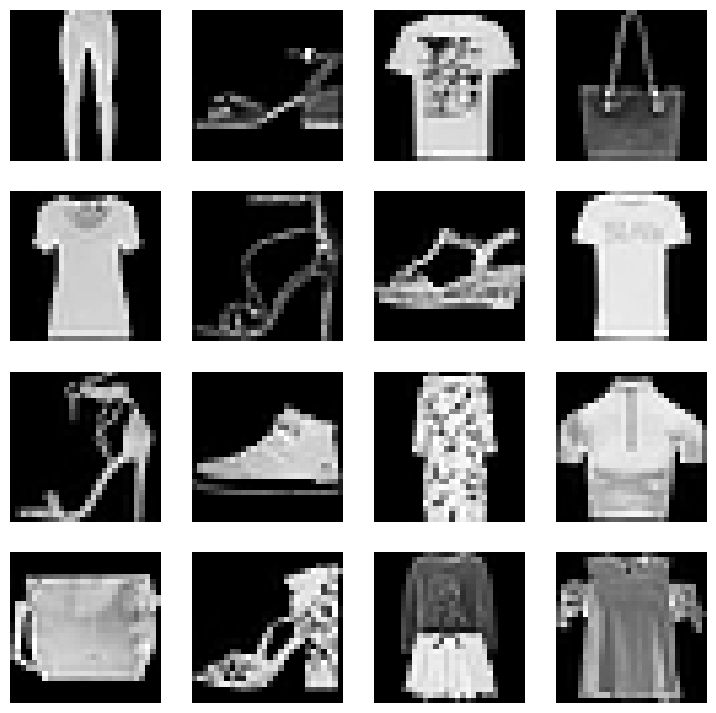

In [7]:
plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_index = random.randint(0, len(x_train))
    plt.subplot(rows, cols, i)
    image= x_train[random_index]
    plt.imshow(image, cmap="gray")
    # plt.title(FashionMNIST_class_names[label])
    plt.axis(False)

plt.savefig("reports_FashionMNIST/FashionMNIST_images_with_label.png")
plt.show()

## Unlabelling The Dataset


In [8]:
percentage_without_labels = 0.8

num_samples_without_labels = int(len(x_train) * percentage_without_labels)
num_samples_with_labels = len(x_train) - num_samples_without_labels

indices_without_labels = np.random.choice(
    range(len(x_train)), size=num_samples_without_labels, replace=False
)
indices_with_labels = np.array(
    [i for i in range(len(x_train)) if i not in indices_without_labels]
)

x_train = np.expand_dims(x_train, axis=-1)
x_train = np.concatenate([x_train] * 3, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_test = np.concatenate([x_test] * 3, axis=-1)

x_train = tf.image.resize(x_train, [32, 32])
x_test = tf.image.resize(x_test, [32, 32])

x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

x_initial = x_train[indices_with_labels]
y_initial = y_train[indices_with_labels]

x_pool = np.delete(x_train, indices_with_labels, axis=0)
y_pool = np.delete(y_train, indices_with_labels, axis=0)

2024-05-05 19:44:49.610997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 19:44:49.611084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 19:44:49.611101: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 19:44:49.611318: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-05 19:44:49.611328: I tensorflow/core/common_runtime/gpu/gpu

In [9]:
x_initial.shape, y_initial.shape, x_pool.shape, y_pool.shape

((12000, 32, 32, 3), (12000, 10), (48000, 32, 32, 3), (48000, 10))

In [10]:
len(x_train)

60000

# Raw Model

## Importing and Using ResNet 50 Architecture


In [11]:
model_ResNet50 = tf.keras.applications.ResNet50(
    weights="imagenet", include_top=False, input_shape=(32, 32, 3)
)
for layer in model_ResNet50.layers[:-2]:
    layer.Trainable=False

model = tf.keras.Sequential(
    [
        model_ResNet50,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)
f1_score = F1Score()
precision = Precision()
model.compile(
    optimizer="Adam",
    loss="CategoricalCrossentropy",
    metrics=["Accuracy", f1_score, precision],
)

In [12]:
def display_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on device {device}: {total_time:.3f} seconds")

## Training


In [13]:
history=model.fit(x_initial, y_initial, epochs=2)

Epoch 1/2


2024-05-05 19:45:01.455300: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-05-05 19:45:03.099262: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1677634500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-05 19:45:03.099304: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2024-05-05 19:45:03.115598: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714927503.222743   29820 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-05-05 19:45:06.091472: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.57GiB with freed_by_count=0. The caller indicates 

375/375 [==============================] - 39s 47ms/step - loss: 0.9672 - Accuracy: 0.7547 - f1_score: 0.7519 - precision: 0.8264
Epoch 2/2
375/375 [==============================] - 18s 47ms/step - loss: 0.7750 - Accuracy: 0.7813 - f1_score: 0.7784 - precision: 0.8346


In [14]:
f1 = [history.history["f1_score"][0].mean(), history.history["f1_score"][1].mean()]

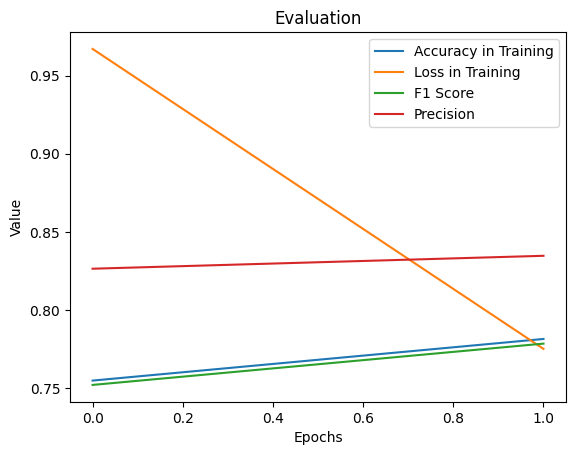

Accuracy in Training: 0.781333327293396
Loss in Training: 0.7749807834625244
F1 Score: 0.7783528566360474
Precision: 0.8346288204193115


In [15]:
fig, ax = plt.subplots()

plt.plot(history.history["Accuracy"], label="Accuracy in Training")
plt.plot(history.history["loss"], label="Loss in Training")
plt.plot(f1, label="F1 Score")
plt.plot(history.history["precision"], label="Precision")
plt.legend()
plt.xlabel("Epochs")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Evaluation")

plt.legend()
plt.savefig("reports_FashionMNIST/raw_model_evaluations_before_al.png")
plt.show()

print(f"Accuracy in Training: {history.history['Accuracy'][-1]}")
print(f"Loss in Training: {history.history['loss'][-1]}")
print(f"F1 Score: {f1[-1]}")
print(f"Precision: {history.history['precision'][-1]}")

In [16]:
model_results = model.evaluate(x_test, y_test)

313/313 [==============================] - 6s 16ms/step - loss: 1.3562 - Accuracy: 0.5467 - f1_score: 0.4724 - precision: 0.7572


## Evaluating Model Visually


1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 22ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 25ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 20ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 21ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


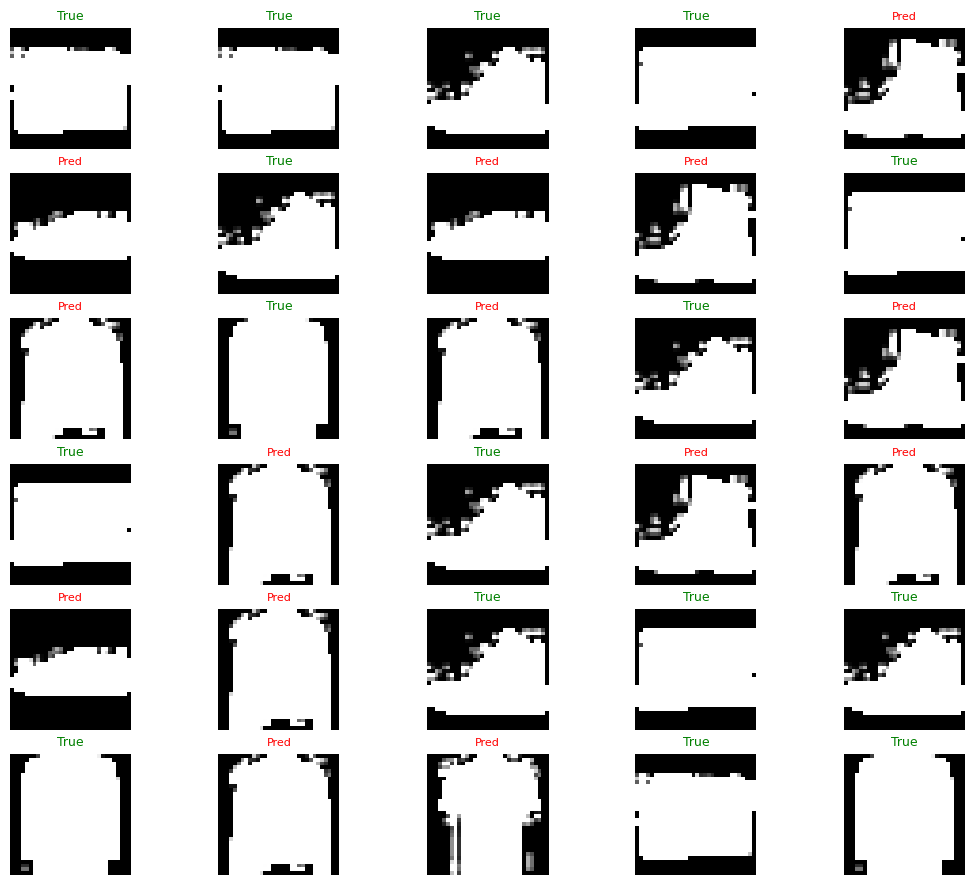

In [17]:
test_samples = []
test_labels = []
idx = np.random.choice(range(len(x_test)), size=9, replace=False)
for sample, label in zip(x_test[idx], y_test[idx]):
    test_samples.append(sample)
    test_labels.append(label)

rows = 6
cols = 5

plt.figure(figsize=(13, 11))

with torch.inference_mode():
    for i in range(1, rows * cols + 1):
        plt.subplot(rows, cols, i)
        random_index = torch.randint(1, 9, size=[1]).item()
        image, label = test_samples[random_index], test_labels[random_index].argmax()
        pred_label = model.predict(image[:, :, :3].reshape(1, 32, 32, 3)).argmax()
        plt.imshow(image)
        
        if pred_label == label:
            plt.title("True", c="g", fontsize=9)
        else:
            plt.title("Pred", c="r", fontsize=8)
        plt.axis(False)

plt.savefig("reports_FashionMNIST/raw_model_predictions_before_al.png")

313/313 [==============================] - 3s 10ms/step


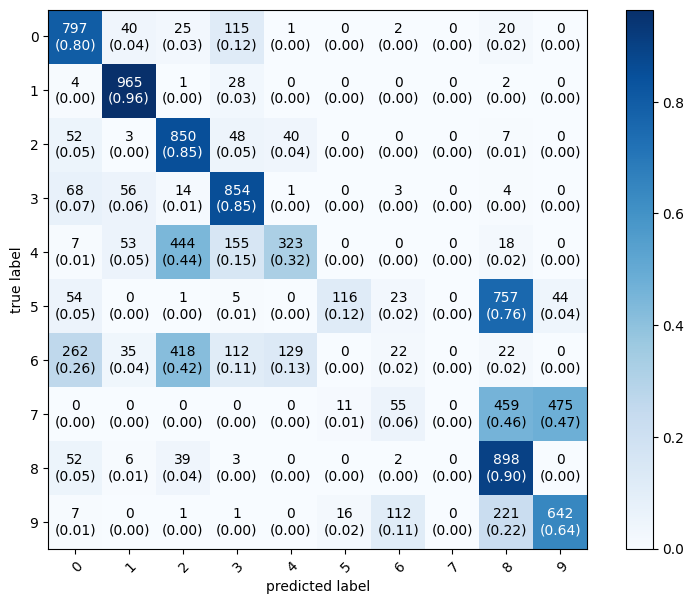

In [18]:
y_pred = model.predict(x_test).argmax(axis=1)
confusion_matrix = multiclass_confusion_matrix(
    torch.tensor(y_pred), torch.tensor(y_test.argmax(axis=1)), num_classes=10
)
plot_confusion_matrix(
    conf_mat=confusion_matrix.numpy(),
    class_names=np.unique(y_test.argmax(axis=1)),
    figsize=(10, 7),
    show_absolute=True,
    show_normed=True,
    colorbar=True,
)

plt.savefig("reports_FashionMNIST/raw_model_confusion_matrix_before_al.png")

## Saving the Model


In [19]:
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "base_model.h5"
MODEL_SAVE_PATH = MODELS_PATH / MODEL_NAME

print(f"Saving model to {MODEL_SAVE_PATH}")
model.save(MODEL_SAVE_PATH)

Saving model to models/base_model.h5


## Load the Model


In [20]:
trained_model = tf.keras.models.load_model(MODEL_SAVE_PATH)

# Active Learning


In [21]:
cycles = 100

In [22]:
trained_model = KerasClassifier(trained_model)

In [23]:
# trained_model.initialize()

In [24]:
def active_learning(pool_x, pool_y, method, model_estimator, num_classes, class_names):
    learner = None
    acc_train = []
    acc_test = []
    precision_result = []
    recall_result = []
    f1_result = []
    loss = []
    if method == "uncertainty_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=uncertainty_sampling)
    elif method == "margin_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=margin_sampling)
    elif method == "entropy_sampling":
        learner = ActiveLearner(estimator=model_estimator, query_strategy=entropy_sampling)
    elif method == "random_sampling":
        def random_sampling(Learner, pool_x, n_instances):
            n_samples = len(pool_x)
            query_idx = np.random.choice(range(n_samples), size=n_instances, replace=False)
            X_query = pool_x[query_idx]
            return query_idx, X_query

        learner = ActiveLearner(estimator=model_estimator, query_strategy=random_sampling)
    elif method == "query_by_committee":
        n_members = 3
        learner_list = list()
        for member_idx in range(n_members):
            Learner = ActiveLearner(estimator=model_estimator)
            learner_list.append(Learner)
        learner = Committee(learner_list=learner_list, query_strategy=vote_entropy_sampling)
    else:
        print("Invalid Input")

    print(f"Starting Active Learning with {method.replace('_', ' ')} method")

    for cycle in range(cycles):
        print(f"Cycle: {cycle + 1}")
        query_idx, _ = learner.query(pool_x, n_instances=100)
        learner.teach(X=pool_x[query_idx], y=pool_y[query_idx])
        pool_x = np.delete(pool_x, query_idx, axis=0)
        pool_y = np.delete(pool_y, query_idx, axis=0)

        model_accuracy = learner.score(x_train, y_train)
        acc_train.append(model_accuracy)
        y_pred = learner.predict(x_test)

        acc_test.append(
            multiclass_accuracy(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        precision_result.append(
            multiclass_precision(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        recall_result.append(
            multiclass_recall(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        f1_result.append(
            multiclass_f1_score(
                torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
            )
        )
        loss.append(
            loss_fn(
                torch.tensor(y_pred, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
            )
        )

        print(f"\tTraining Accuracy: {acc_train[-1]:.3f}")
        print(f"\tTesting Accuracy: {acc_test[-1]:.3f}")
        print(f"\tPrecision: {precision_result[-1]:.3f}")
        print(f"\tRecall: {recall_result[-1]:.3f}")
        print(f"\tF1 Score: {f1_result[-1]:.3f}")
        print(f"\tLoss: {loss[-1]:.3f}")

        try:
            slope = (loss[-1] - loss[-10]) / 9
            print("\tSlop after 10 Epochs", slope)
            if slope >= 0.01:
                break
        except Exception:
            continue

    print(f"Active Learning with {method} method is finished")
    confusion_matrix = multiclass_confusion_matrix(
        torch.tensor(y_pred), torch.tensor(y_test), num_classes=num_classes
    )
    plot_confusion_matrix(
        conf_mat=confusion_matrix.numpy(),
        class_names=class_names,
        figsize=(10, 7),
        show_absolute=True,
        show_normed=True,
        colorbar=True,
    )

    plt.savefig(f"reports_FashionMNIST/{method}_confusion_matrix_after_al.png")
    return {
        "Train Accuracy": acc_train,
        "Test Accuracy": acc_test,
        "Precision": precision_result,
        "Recall": recall_result,
        "F1 Score": f1_result,
        "Loss": loss
    }

## Random Sampling

In [25]:
results_random_sampling = active_learning(x_pool, y_pool, "random_sampling", trained_model, 10, np.unique(y_test.argmax(axis=1)))

Starting Active Learning with random sampling method
Cycle: 1
3/4 [=====================>........] - ETA: 0s - loss: 2.0250 - Accuracy: 0.6250 - f1_score: 0.5321 - precision: 0.6742

2024-05-05 19:46:26.318574: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-05 19:46:26.324729: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


4/4 [==============================] - 18s 746ms/step - loss: 1.9700 - Accuracy: 0.6300 - f1_score: 0.5390 - precision: 0.6774


: 

## Uncertainty Sampling

In [ ]:
results_uncertainty_sampling = active_learning(x_pool, y_pool, "uncertainty_sampling", trained_model, 10, FashionMNIST_class_names)

## Margin Sampling

In [ ]:
results_margin_sampling = active_learning(x_pool, y_pool, "margin_sampling", trained_model, 10, FashionMNIST_class_names)

## Entropy Sampling

In [ ]:
results_entropy_sampling = active_learning(x_pool, y_pool, "entropy_sampling", trained_model, 10, FashionMNIST_class_names)

## Query by Committee

In [ ]:
results_committee_sampling = active_learning(x_pool, y_pool, "query_by_committee", trained_model, 10, FashionMNIST_class_names)

# Plot All Metrics


## Accuracy


In [ ]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Train Accuracy"], label="Train Accuracy Random")
plt.plot(results_random_sampling["Test Accuracy"], label="Test Accuracy Random")
plt.plot(results_uncertainty_sampling["Train Accuracy"], label="Train Accuracy Uncertainty")
plt.plot(results_uncertainty_sampling["Test Accuracy"], label="Test Accuracy Uncertainty")
plt.plot(results_margin_sampling["Train Accuracy"], label="Train Accuracy Margin")
plt.plot(results_margin_sampling["Test Accuracy"], label="Test Accuracy Margin")
plt.plot(results_entropy_sampling["Train Accuracy"], label="Train Accuracy Entropy")
plt.plot(results_entropy_sampling["Test Accuracy"], label="Test Accuracy Entropy")
plt.plot(results_committee_sampling["Train Accuracy"], label="Train Accuracy Committee")
plt.plot(results_committee_sampling["Test Accuracy"], label="Test Accuracy Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Train Accuracy & Test Accuracy")
plt.legend()
plt.savefig("reports_FashionMNIST/model_after_al_accuracy.png")
plt.show()

print(f"Train Accuracy Random: {results_random_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Random: {results_random_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Uncertainty: {results_uncertainty_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Uncertainty: {results_uncertainty_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Margin: {results_margin_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Margin: {results_margin_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Entropy: {results_entropy_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Entropy: {results_entropy_sampling['Test Accuracy'][-1]}")
print(f"Train Accuracy Committee: {results_committee_sampling['Train Accuracy'][-1]}")
print(f"Test Accuracy Committee: {results_committee_sampling['Test Accuracy'][-1]}")

## Loss

In [ ]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Loss"], label="Random")
plt.plot(results_uncertainty_sampling["Loss"], label="Uncertainty")
plt.plot(results_margin_sampling["Loss"], label="Margin")
plt.plot(results_entropy_sampling["Loss"], label="Entropy")
plt.plot(results_committee_sampling["Loss"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Loss")
plt.legend()
plt.savefig("reports_FashionMNIST/model_after_al_loss.png")
plt.show()

print(f"Random: {results_random_sampling['Loss'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Loss'][-1]}")
print(f"Margin: {results_margin_sampling['Loss'][-1]}")
print(f"Entropy: {results_entropy_sampling['Loss'][-1]}")
print(f"Committee: {results_committee_sampling['Loss'][-1]}")

## Precision


In [ ]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Precision"], label="Random")
plt.plot(results_uncertainty_sampling["Precision"], label="Uncertainty")
plt.plot(results_margin_sampling["Precision"], label="Margin")
plt.plot(results_entropy_sampling["Precision"], label="Entropy")
plt.plot(results_committee_sampling["Precision"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Precision")
plt.legend()
plt.savefig("reports_FashionMNIST/model_after_al_precision.png")
plt.show()

print(f"Random: {results_random_sampling['Precision'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Precision'][-1]}")
print(f"Margin: {results_margin_sampling['Precision'][-1]}")
print(f"Entropy: {results_entropy_sampling['Precision'][-1]}")
print(f"Committee: {results_committee_sampling['Precision'][-1]}")

## Recall


In [ ]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["Recall"], label="Random")
plt.plot(results_uncertainty_sampling["Recall"], label="Uncertainty")
plt.plot(results_margin_sampling["Recall"], label="Margin")
plt.plot(results_entropy_sampling["Recall"], label="Entropy")
plt.plot(results_committee_sampling["Recall"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Recall")
plt.legend()
plt.savefig("reports_FashionMNIST/model_after_al_recall.png")
plt.show()

print(f"Random: {results_random_sampling['Recall'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['Recall'][-1]}")
print(f"Margin: {results_margin_sampling['Recall'][-1]}")
print(f"Entropy: {results_entropy_sampling['Recall'][-1]}")
print(f"Committee: {results_committee_sampling['Recall'][-1]}")

## F1 Score


In [ ]:
plt.figure(figsize=(13, 11))

plt.plot(results_random_sampling["F1 Score"], label="Random")
plt.plot(results_uncertainty_sampling["F1 Score"], label="Uncertainty")
plt.plot(results_margin_sampling["F1 Score"], label="Margin")
plt.plot(results_entropy_sampling["F1 Score"], label="Entropy")
plt.plot(results_committee_sampling["F1 Score"], label="Committee")

plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("F1 Score")
plt.legend()
plt.savefig("reports_FashionMNIST/model_after_al_f1_score.png")
plt.show()

print(f"Random: {results_random_sampling['F1 Score'][-1]}")
print(f"Uncertainty: {results_uncertainty_sampling['F1 Score'][-1]}")
print(f"Margin: {results_margin_sampling['F1 Score'][-1]}")
print(f"Entropy: {results_entropy_sampling['F1 Score'][-1]}")
print(f"Committee: {results_committee_sampling['F1 Score'][-1]}")

In [ ]:
import shutil
shutil.rmtree('/kaggle/working/models')
shutil.rmtree('/kaggle/working/data_FashionMNIST')